#  LWR model: kernel parameter influence and prediction interval

### Figure 5

In [1]:
"""
 LWR model: kernel parameter influence and prediction interval
"""
import numpy as np 
import math
import pylab as pl
from scipy import stats
from matplotlib import rc
import pickle as p
import matplotlib.pyplot as plt

rc('text', usetex=True)
plt.rcParams["font.family"] = "Times New Roman"

def gaussianKernel(x, x0, k):
    d2 = (x-x0)**2 
    resul = math.exp(-d2 / (2.0 * (k**2)))
    return resul


def getWeights(D, x, k):
    n = len(D)           
    weights = np.eye(n) 
    for i in range(n):
        x0 = D[i][0]
        weights[i,i] = gaussianKernel(x, x0, k)

    return weights


def lwr(D, coordX, k):
    
    beta = []
    try:
        W = getWeights(D, coordX, k)  
        m = len(D)
        X = D[:,:-1]                   
        X = np.c_[np.ones(m),X]        
        y = D[:,1]                     
            
        Xt = np.transpose(X)
        Xt_W = np.dot(Xt,W)
        M5 = np.dot(W, X)
        Xt_W_X = np.dot(Xt_W,M5)
        Xt_W_X_INV = np.linalg.inv(Xt_W_X)
        M6  = np.dot(W, y)
        Xt_W_y = np.dot(Xt_W,M6)
        beta = np.dot(Xt_W_X_INV,Xt_W_y)
        
        Xi  = np.array([1,coordX])
        Xit = np.transpose(Xi)
        resul = np.dot(Xit,beta)
        
        
        
        #Student’s t-value:
        sw = 0                      
        for i in range(m):          
            sw += W[i][i]**2        
        #print W
        pl = (sw/m)*2.0                # p' = (n'/n)*p. 
        t = stats.t.ppf(0.95, sw-pl )  
        
        #Variance
        Xb_y = np.dot(X,beta) - y
        Xb_y_t_W = np.dot(np.transpose(Xb_y), W)
        W_Xb_y   = np.dot(W, Xb_y)
        M1       = np.dot(Xb_y_t_W, W_Xb_y) 
        s = math.sqrt(M1/(sw-pl))
        print ("\nVariance: ",s," T-value:",t)
        
        
        #Prediction Interval
        M2 = np.dot(np.transpose(Xi), Xt_W_X_INV)
        M2 = np.dot(M2, Xi)
        I = t * s * math.sqrt(1.0 + M2 )
        print ("Prediction Interval:",I)
        
        
        #Validation
        resul_tol = abs(resul) *  (10.0/100.0)
        print ("Resul:",resul_tol) 
        resul_inter1 = I              
        resul_inter2 = resul - I
        
        
        return resul, I, resul_inter2, resul_tol
        
    except Exception as erro:
        print ("\nError LWR\n",erro)
        
        return None


def fun_k(d, k):
    resul = math.exp(- d**2 / (2.0 * (k**2)))
    return resul


if __name__ == '__main__':
       
    #Random values 
    n = 50
    x = np.linspace(0, 2 * math.pi, n)
    y = -(np.sin(x) + (x*0.4)+  0.26 * np.random.randn(n)) + 9
    
    #Paper figure values, using the above function (Random values)
    x = [0.0, 0.12822827, 0.25645654, 0.38468481, 0.51291309, 0.64114136, 0.76936963, 0.8975979, 1.02582617, 1.15405444, 1.28228272, 1.41051099, 1.53873926, 1.66696753, 1.7951958, 1.92342407, 2.05165235, 2.17988062, 2.30810889, 2.43633716, 2.56456543, 2.6927937, 2.82102197, 2.94925025, 3.07747852, 3.2057079, 3.33393506, 3.46216333, 3.5903916, 3.71861988, 3.84684815, 3.97507642, 4.10330469, 4.23153296, 4.35976123, 4.48798951, 4.61621778, 4.74444605, 4.87267432, 5.00090259, 5.12913086, 5.25735913, 5.38558741, 5.51381568, 5.64204395, 5.77027222, 5.89850049, 6.02672876, 6.15495704, 6.28318531]
    y = [8.93446359, 8.82549389, 8.61408279, 8.68128181, 8.35711753, 8.52778827, 8.38406577, 7.95410365, 7.87939614, 7.65064497, 7.706772, 7.44422381, 7.6403827, 7.41163932, 7.40273201, 7.10664719, 7.20110526, 7.01424463, 7.35089557, 7.01224345, 7.91767263, 7.22750098, 7.6960383, 7.47129079, 7.92588049, 7.60063147, 7.9241082, 8.18693755, 7.73461531, 7.90484923, 7.95133447, 7.99553315, 8.39431956, 8.3591708, 8.39075941, 8.15012021, 7.76510346, 8.41860853, 8.15652765, 7.83990192, 7.95533785, 7.57943602, 7.42713946, 7.4293742, 6.88072717, 7.24124492, 6.81430224, 6.58477878, 7.04062477, 6.68575656] 
    
    y = np.array(y)
    D = np.c_[np.transpose(x),np.transpose(y)]

#     print (x)
#     print (y)
#     print (D)
    
    x_infer = np.linspace(0, 2 * math.pi,n)
    y_infer = np.zeros(n)
    z_infer = np.zeros(n)
    z = np.zeros(n)
    w =  np.zeros(n)
    intervalo_Erro = np.zeros(n)
    intervalo_Erro2 = np.zeros(n)
    intervalo_Erro3 = np.zeros(n)
    tolerancia = np.zeros(n)
    print("Predictions...")
    for i in range(len(x_infer)):
        #z[i] = fun_k(x[i],1.5)
        #y[i] = fun_k(x[i], 3.0) 
        #B = lwr(D, x_infer[i], k) 
        y_infer[i], intervalo_Erro3[i], intervalo_Erro2[i], tolerancia[i] = lwr(D, x_infer[i], 1)
        z_infer[i], intervalo_Erro[i], intervalo_Erro2[i], tolerancia[i] = lwr(D, x_infer[i],3 ) 
      
    

Predictions...

Variance:  0.11911202462079454  T-value: 1.8899867778189017
Prediction Interval: 0.2595654435418511
Resul: 0.8943347822836127

Variance:  0.4909040691222272  T-value: 1.7233629651288236
Prediction Interval: 0.8980465787429577
Resul: 0.8323475154644474

Variance:  0.1251694212611505  T-value: 1.857778357736592
Prediction Interval: 0.2580647377829553
Resul: 0.8820728284510809

Variance:  0.4940819138460626  T-value: 1.7197149647249794
Prediction Interval: 0.8958424060618477
Resul: 0.8273804183828197

Variance:  0.13238830072940613  T-value: 1.8340894434370287
Prediction Interval: 0.26284533871944027
Resul: 0.8697485123287807

Variance:  0.4968847987915153  T-value: 1.7164161439828747
Prediction Interval: 0.8939685872888551
Resul: 0.8227117458034487

Variance:  0.14121604846899427  T-value: 1.816490257864807
Prediction Interval: 0.2732716588182365
Resul: 0.8574349763757558

Variance:  0.49931061627025025  T-value: 1.7134307204529122
Prediction Interval: 0.8922940610892955


<Figure size 432x288 with 0 Axes>

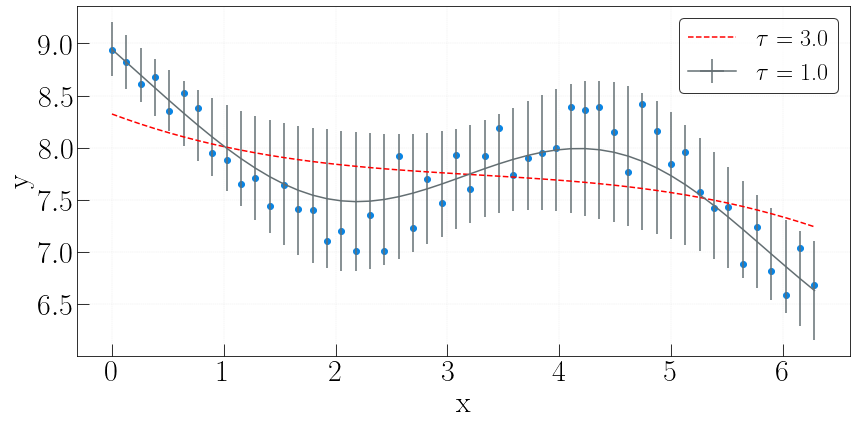

In [2]:
    pl.clf()
    fig, ax = pl.subplots(figsize=(12, 6))
    
    pl.plot(x_infer, z_infer, label=r'$\tau$ = 3.0', c='r', linestyle='dashed')
    pl.errorbar(x_infer, y_infer, xerr=0, yerr= intervalo_Erro3, c = '#636e72', label=r'$\tau$ = 1.0')
    
    pl.scatter(x,y, c= '#0984e3')
    
    ax.set_xlabel('x' , fontsize=30)
    ax.set_ylabel('y' , fontsize=30)
    ax.yaxis.grid(color='silver', linestyle='--', linewidth=0.4, alpha=0.4)
    ax.xaxis.grid(color='silver', linestyle='--', linewidth=0.4, alpha=0.4)
    ax.tick_params(direction='in', length=12)
    
    pl.yticks(fontsize=30)
    pl.xticks(fontsize=30)

    pl.legend(prop={'size': 24},edgecolor='black')
    fig.tight_layout()
    pl.show()
    fig.savefig("fig/lwr-compare.pdf")